In [1]:
# Import data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from formations import Side, get_relative_tracking, plot_all_formations, train_k_means, train_dbscan, plot_model

# Load Data

In [13]:
tracking = pd.DataFrame()

for week_nbr in range(1,5):
    tracking = pd.concat((tracking, pd.read_csv(f'data/week{week_nbr}.csv')))

players = pd.read_csv('data/players.csv')

tracking = tracking.merge(players, on='nflId')

In [14]:
tracking.head()

,gameId,playId,nflId,frameId,team,playDirection,x,y,event,height,weight,birthDate,collegeName,officialPosition,displayName
0,2021090900,97,25511.0,1,TB,right,37.77,24.22,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,2021090900,97,25511.0,2,TB,right,37.78,24.22,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
2,2021090900,97,25511.0,3,TB,right,37.78,24.24,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
3,2021090900,97,25511.0,4,TB,right,37.73,24.25,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
4,2021090900,97,25511.0,5,TB,right,37.69,24.26,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady


# Process Data

In [4]:
# choose offense or defense
team = 'offense'

In [5]:
# Get offense and defense teams based on which team has the Center
center_teams = tracking.groupby(['playId', 'officialPosition']).agg({'team': 'first'}).reset_index().query('officialPosition == "C"')[['playId', 'team']]

defense_teams = tracking.groupby(['playId', 'team']).agg({'officialPosition': 'first'}).reset_index()[['playId', 'team']]
defense_teams = defense_teams.merge(center_teams.drop_duplicates(), on=['playId','playId'], how='left')
defense_teams['isDefense'] = defense_teams.apply(lambda x: 1 if x['team_x'] != x['team_y'] else 0, axis=1)
defense_teams = defense_teams[defense_teams['isDefense'] == 1][['playId', 'team_x']]
defense_teams.columns = ['playId', 'team']


offense = tracking.merge(center_teams, on=['playId', 'team'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').query('event == "ball_snap"')
defense = tracking.merge(defense_teams, on=['playId', 'team'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').query('event == "ball_snap"')
    
offense_rel_tracking = get_relative_tracking(offense, defense, Side.OFFENSE)
defense_rel_tracking = get_relative_tracking(offense, defense, Side.DEFENSE)

In [6]:
# Get personnel groups
top_offense_personnel_package = offense_rel_tracking['personnel'].value_counts().index[0]
top_defense_personnel_package = defense_rel_tracking['personnel'].value_counts().index[0]

top_offense_personnel_package, top_defense_personnel_package

('C G G QB RB T T TE WR WR WR', 'CB CB CB DE DE DT DT FS MLB OLB SS')

# Plot All Formations

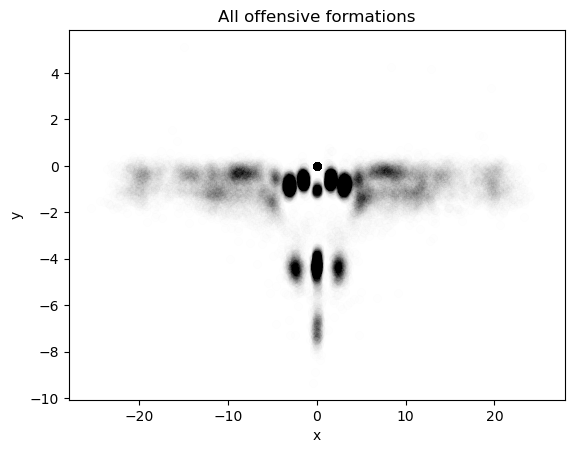

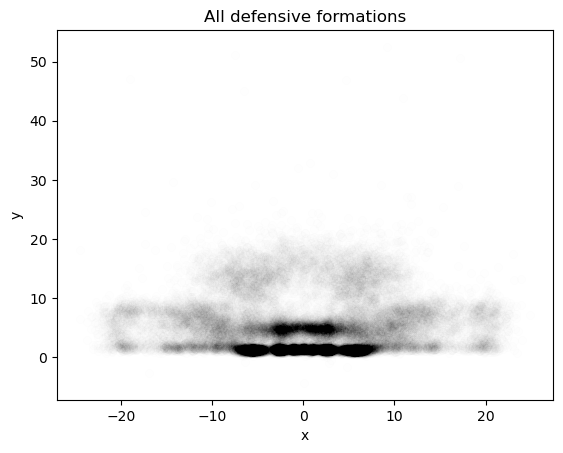

In [7]:
plot_all_formations(offense_rel_tracking, Side.OFFENSE)
plot_all_formations(defense_rel_tracking, Side.DEFENSE)

# Select Personnel Group

In [8]:
offense_specific_personnel_tracking = offense_rel_tracking.query('personnel == @top_offense_personnel_package')
defense_specific_personnel_tracking = defense_rel_tracking.query('personnel == @top_defense_personnel_package')

# K-means

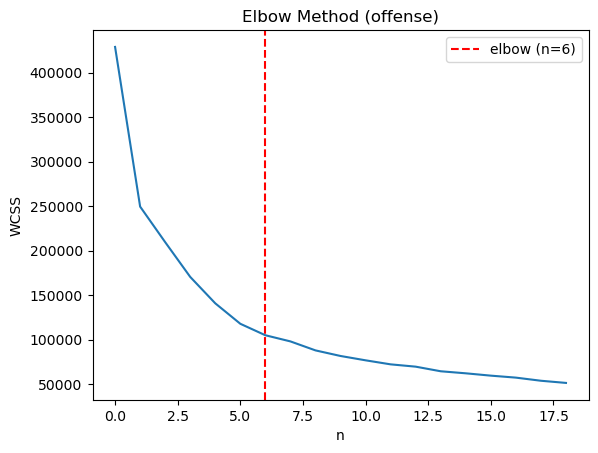

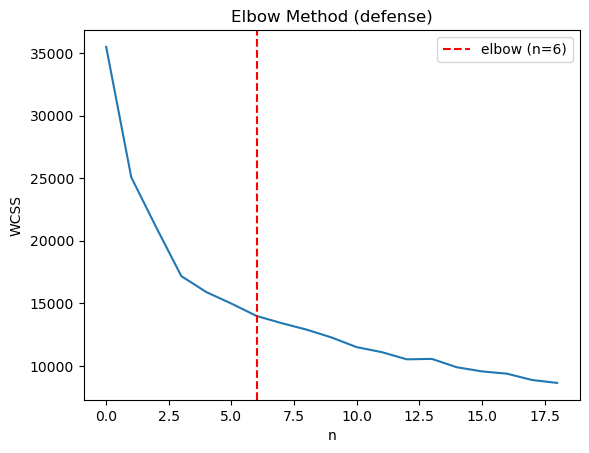

In [9]:
km_offense, predictions_offense = train_k_means(offense_specific_personnel_tracking, Side.OFFENSE)
km_defense, predictions_defense = train_k_means(defense_specific_personnel_tracking, Side.DEFENSE)

# DBSCAN

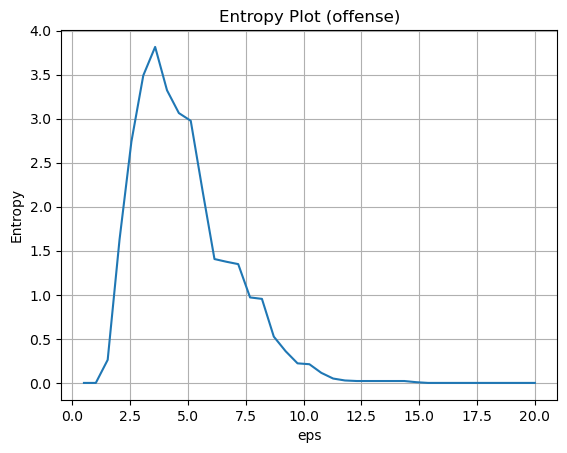

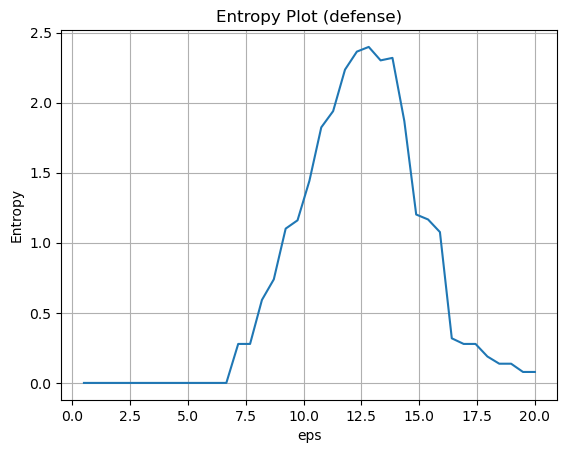

In [10]:
db_offense, predictions_offense = train_dbscan(offense_specific_personnel_tracking, Side.OFFENSE)
db_defense, predictions_defense = train_dbscan(defense_specific_personnel_tracking, Side.DEFENSE)

# Plot results

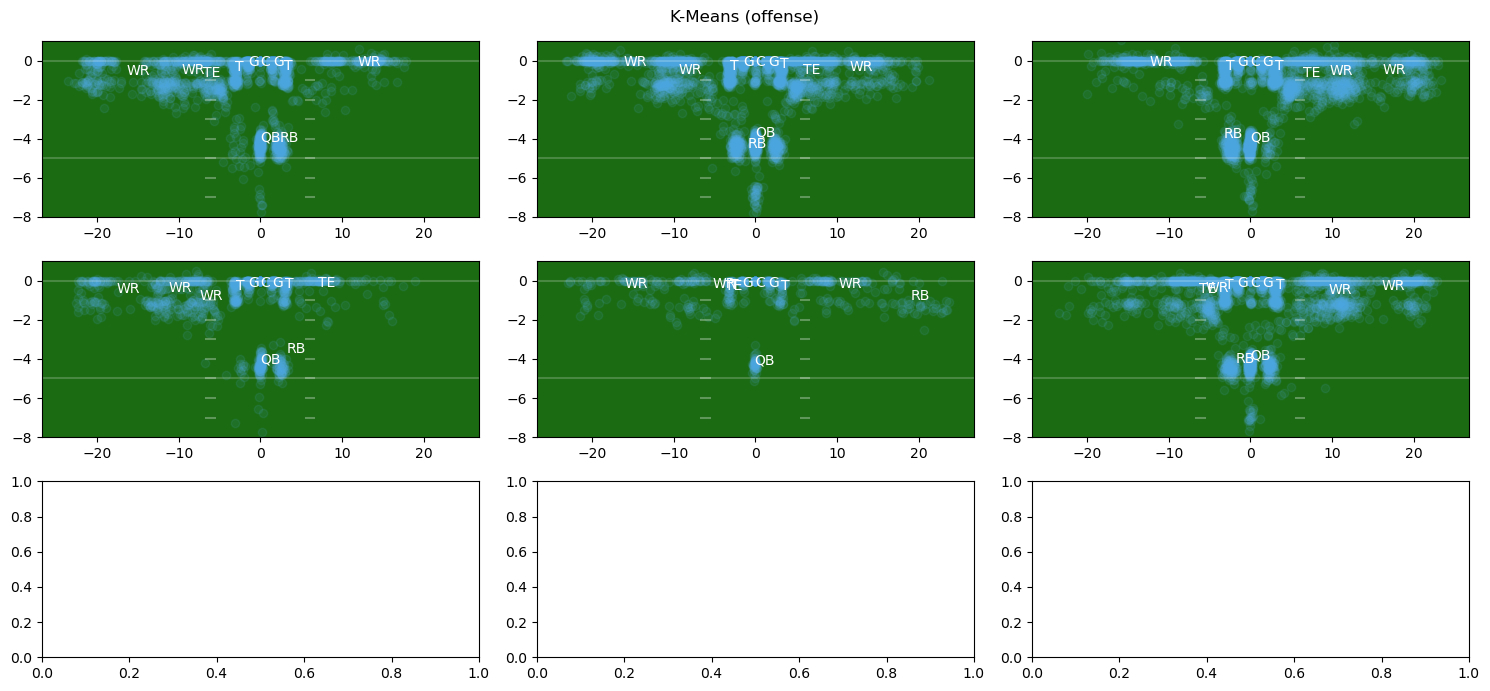

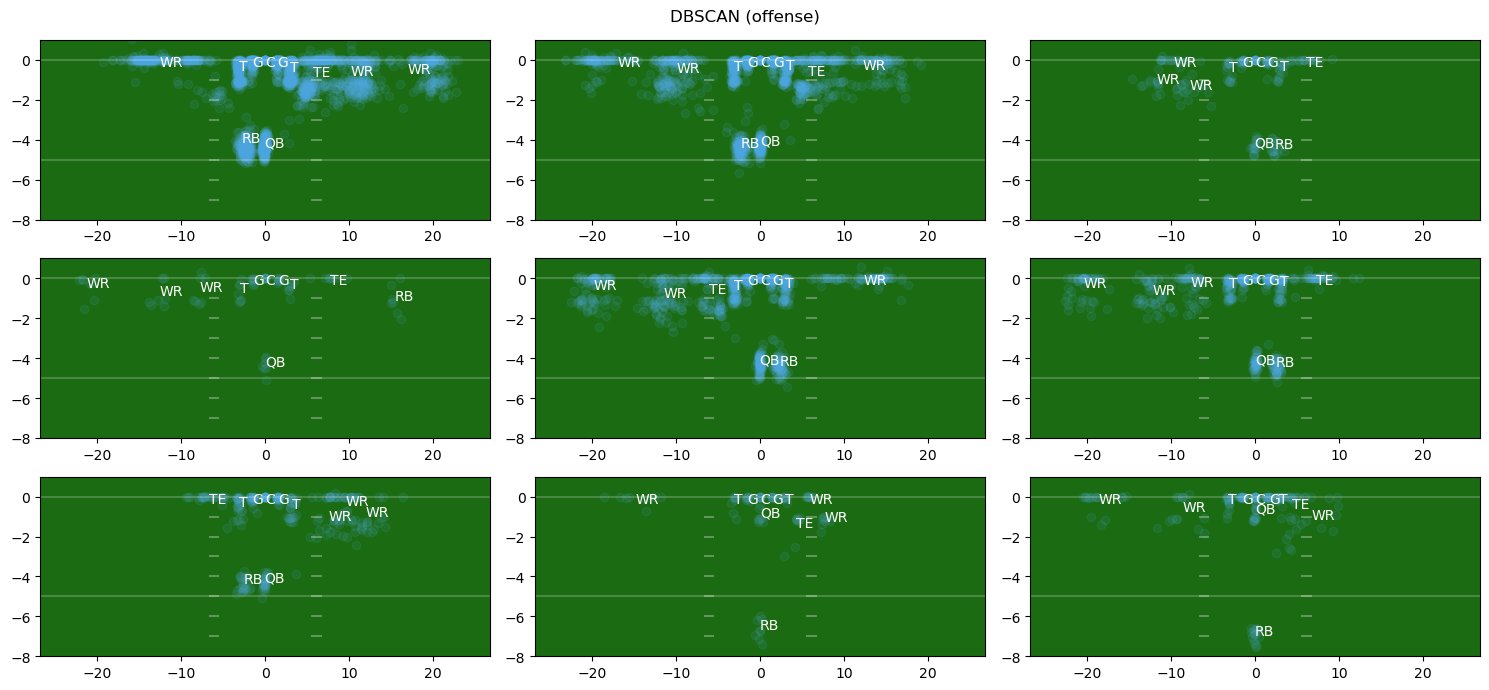

In [11]:
plot_model(offense_specific_personnel_tracking, km_offense, Side.OFFENSE)
plot_model(offense_specific_personnel_tracking, db_offense, Side.OFFENSE)

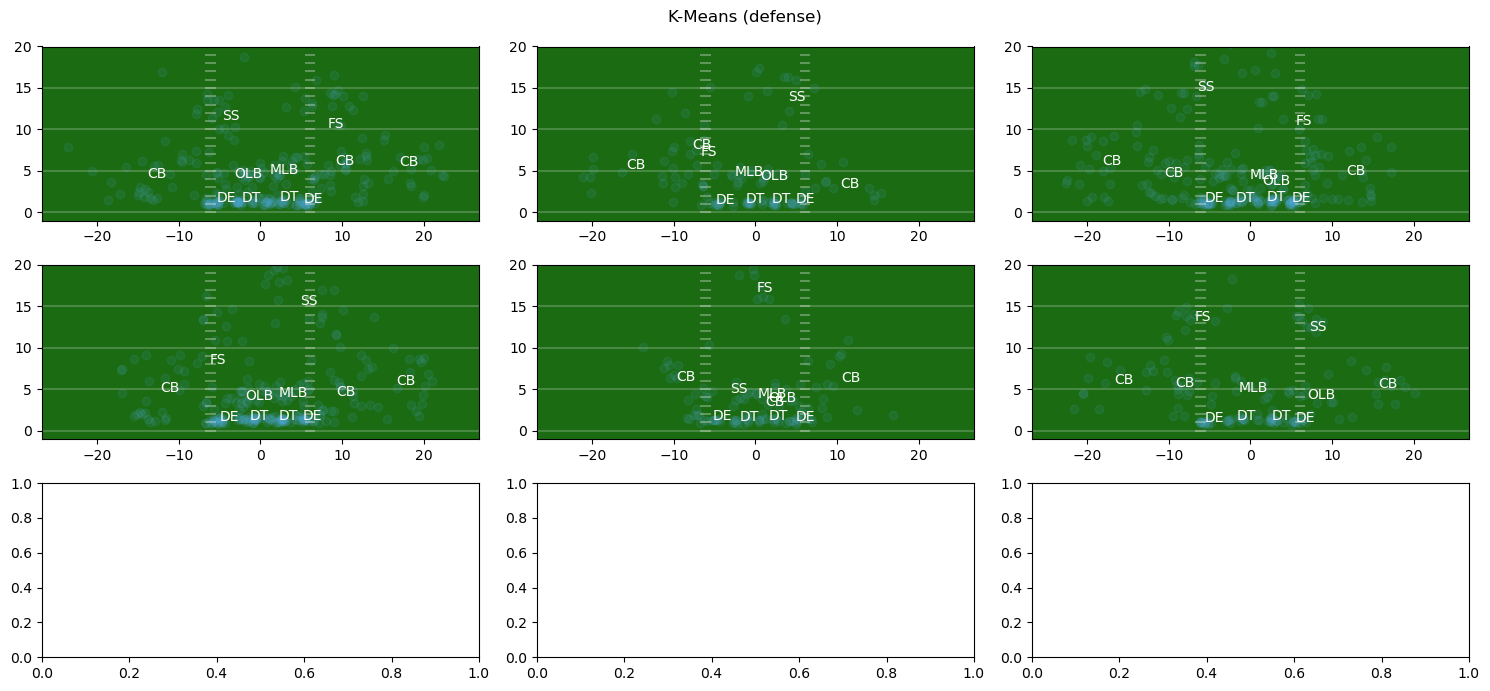

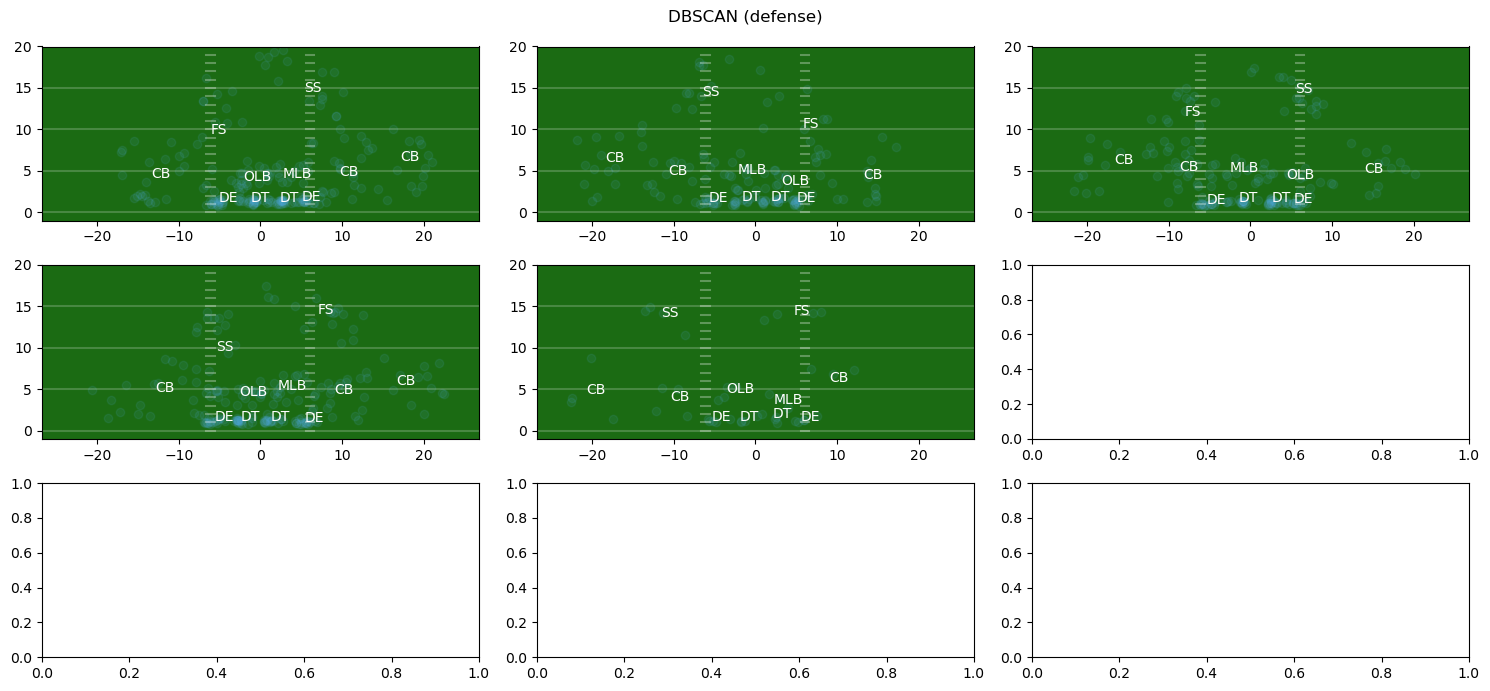

In [12]:
plot_model(defense_specific_personnel_tracking, km_defense, Side.DEFENSE)
plot_model(defense_specific_personnel_tracking, db_defense, Side.DEFENSE)